# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
!python --version

Python 3.9.0


In [2]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cpu


In [4]:
!pip install gym[atari]

SyntaxError: invalid syntax (<ipython-input-4-ba93f0fec10b>, line 1)

In [3]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



In [ ]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import numpy as np
def output_volume(in_dims, k=3, s=2, p=0, transpose=False):
    ''' Calculate a convolutional layer's output size params:
        in_dims = input size (int)
        k = kernel size 
        s = stride (int)
        p = padding (int)
    '''
    if not transpose:
        out_size = (in_dims - k + 2*p)/s + 1 #convolution out
    else:
        out_size = (in_dims - 1)*s + k - 2*p #deconvolution out
    return int(np.floor(out_size))

In [5]:
output_volume(26, 6, 3, 0), 7*7*16, 80*80*2, 784/7

(7, 784, 12800, 112.0)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
                        #self.batchnorm = nn.BatchNorm2d()
        # 2 channel from the stacked frame
        # 80x80x2 to 26x26x8
        self.conv1 = nn.Conv2d(2, 8, kernel_size=5, stride=3, padding=1, bias=False)
        # 26x26x8 to 7x7x16
        self.conv2 = nn.Conv2d(8, 16, kernel_size=6, stride=3)
        self.size=7*7*16  #=784
        
        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 112) # =7*16
        self.fc2 = nn.Linear(112, 1)

        # Sigmoid to 
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))

In [7]:
# run your own policy!
policy=Policy().to(device)

 # Solution policy:
#policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

In [ ]:
pong_utils.play(env, policy, time=200) 

# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [ ]:
discount=0.99
rewards=np.random.rand(64)
discount = discount**np.arange(64)
discount

In [ ]:
rewards#.shape# = np.asarray(rewards)*discount[:,np.newaxis]
#discount[:,np.newaxis].shape

In [ ]:
#rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
#rewards_future.shape
rewards[::-1].cumsum(axis=0).shape#[::-1]

In [8]:
def clipped_surrogate(policy, old_probs, states, actions, rewards, discount = 0.995, epsilon=0.1, beta=0.01):
    ## WRITE YOUR OWN CODE HERE  ## from plot_utils
    #####################?
    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    ######################?
    
    # move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)

    # ratio for clipping
    ratio = new_probs/old_probs

    # clipped function
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)
    
    # include a regularization term
    # this steers new_policy towards 0.5
    # prevents policy to become exactly 0 or 1 helps exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+(1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    # this returns an average of all the entries of the tensor
    # effective computing L_sur^clip / T
    # averaged over time-step and number of trajectories
    # this is desirable because we have normalized our rewards
    return torch.mean(clipped_surrogate + beta*entropy)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [9]:
from parallelEnv import parallelEnv
import numpy as np

# widget bar to display progress
!pip install progressbar
import progressbar as pb

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


In [12]:
envs = parallelEnv('PongDeterministic-v4', n=12, seed=1234)

discount_rate = .992  #
epsilon = 0.1  #
beta = .01     #
tmax = 1000    # training loop max = ? 
SGD_epoch = 8  #

# episodes = number episode batches to collect?
# WARNING: running through all 800 episodes will take 30-45 minutes
episodes = 20  #800

def train(policy, envs, episodes, tmax, SGD_epoch, gamma=discount_rate, epsilon=epsilon, beta=beta):

    # keep track of progress
    mean_rewards = []

    # keep track of how long training takes
    widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
    timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()

    for e in range(episodes):

        # collect trajectories
        old_probs, states, actions, rewards = pong_utils.collect_trajectories(envs, policy, tmax=tmax)

        total_rewards = np.sum(rewards, axis=0)

        # gradient ascent step
        for _ in range(SGD_epoch):

            # uncomment to utilize your own clipped function!
            L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

            #L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)
            optimizer.zero_grad()
            L.backward()
            optimizer.step()
            del L

        # the clipping parameter reduces as time goes on
        epsilon*=.999

        # the regulation term also reduces
        # this reduces exploration in later runs
        beta*=.995

        # get the average reward of the parallel environments
        mean_rewards.append(np.mean(total_rewards))

        # display some progress every 20 iterations
        if (e+1)%20 ==0 :
            print("Episode: {0:d}, Avg. score: {1:f}".format(e+1,np.mean(total_rewards)))
            print(total_rewards)

        # update progress widget bar
        timer.update(e+1)

    timer.finish()
    return mean_rewards

Process Process-41:
Process Process-44:
Process Process-40:
Process Process-42:
Process Process-39:
Process Process-34:
Process Process-37:
Process Process-35:
Process Process-33:
Process Process-36:
Process Process-38:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-43:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, 

KeyboardInterrupt
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


In [14]:
# Hyperparameter Control 
#envs = parallelEnv('PongDeterministic-v4', n=16, seed=1234)
discount_rate = .99  #
epsilon = 0.075  #
beta = .01     #
tmax = 800    # 1000 training loop max = ? 
SGD_epoch = 4  #
episodes = 100  #800

mean_rewards += train(policy, envs, episodes, tmax, SGD_epoch, gamma=discount_rate, epsilon=epsilon, beta=beta)

Episode: 20, Avg. score: -17.562500
[-19. -16. -19. -16. -16. -16. -20. -17. -17. -20. -20. -17. -17. -20. -17.
 -14.]


Episode: 40, Avg. score: -16.250000
[-16. -19. -17. -18. -19. -18. -14. -18. -18. -20. -19. -12. -10. -14. -13.
 -15.]


Episode: 60, Avg. score: -13.875000
[-14. -12. -18. -13. -12. -12. -15. -16. -12. -14. -12. -12. -14. -14. -16.
 -16.]


Episode: 80, Avg. score: -10.000000
[ -9. -10. -13.  -6. -14.  -6.  -8. -10. -10. -10.  -6. -10. -13. -14.  -7.
 -14.]


Episode: 100, Avg. score: -6.687500
[-13.  -7.  -9.  -8.  -9.  -5.  -2.  -5.  -3.  -2.  -9.  -7.  -5.  -9.  -4.
 -10.]


In [ ]:
mean_rewards = train(policy, envs, episodes, tmax, SGD_epoch, gamma=discount_rate, epsilon=epsilon, beta=beta)


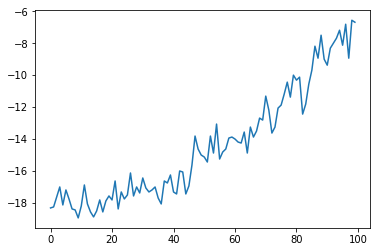

In [15]:
plt.plot(mean_rewards)

In [ ]:
pong_utils.play(env, policy, time=200) 

In [16]:
# save your policy!
torch.save(policy, 'PPO_X.policy')

# load policy if needed
#policy = torch.load('PPO.policy')
#pong_utils.play(env, policy, time=1000) 

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
#policy_solution = torch.load('PPO_solution.policy')
#pong_utils.play(env, policy_solution, time=1000) 

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
